In [5]:
%run ../src/simulation.py
%run ../src/augmentation.py

In [232]:
import numpy as np
from functools import partial
from scipy.spatial.distance import euclidean, cosine, cityblock


def warmup_burnin(n_iter, population, birth_date):
    return birth_date.max() >= n_iter


def turnover_burnin(initial_traits, population, *args):
    return population.min() >= initial_traits


def run_model(burnin_fn, n_agents, beta=0.0, mu=0.01, p_death=0.5):
    
    simulator = Simulator(n_agents=n_agents, timesteps=1)
    hill = HillNumbers(q_step=0.1)

    population = np.random.choice(2, size=n_agents)
    birth_date = np.ceil(np.random.random(n_agents) * 50).astype(np.int64)
    n_traits = len(np.unique(population))
    
    while not burnin_fn(population, birth_date):
        population, birth_date, n_traits, novel = simulator._get_dynamics(
            beta, mu, p_death, population, birth_date, n_traits)
        yield hill(np.bincount(reindex_array(population))[:, None])[0]
        
        
def monitor_distances(burnin_fn, n_agents, max_iter=10_000, beta=0.0, mu=0.01, 
                      p_death=0.5, dist_fn=euclidean):
    model_run = run_model(burnin_fn, n_agents, beta, mu, p_death)
    distances = []
    current_hill = None
    for i, hill in enumerate(model_run):
        if i % 10 == 0:
            if current_hill is not None:
                distances.append(dist_fn(hill, current_hill))
                richness_distances.append(abs(hill[0] - current_hill[0]))
            current_hill = hill
        if i > max_iter:
            break
    return distances

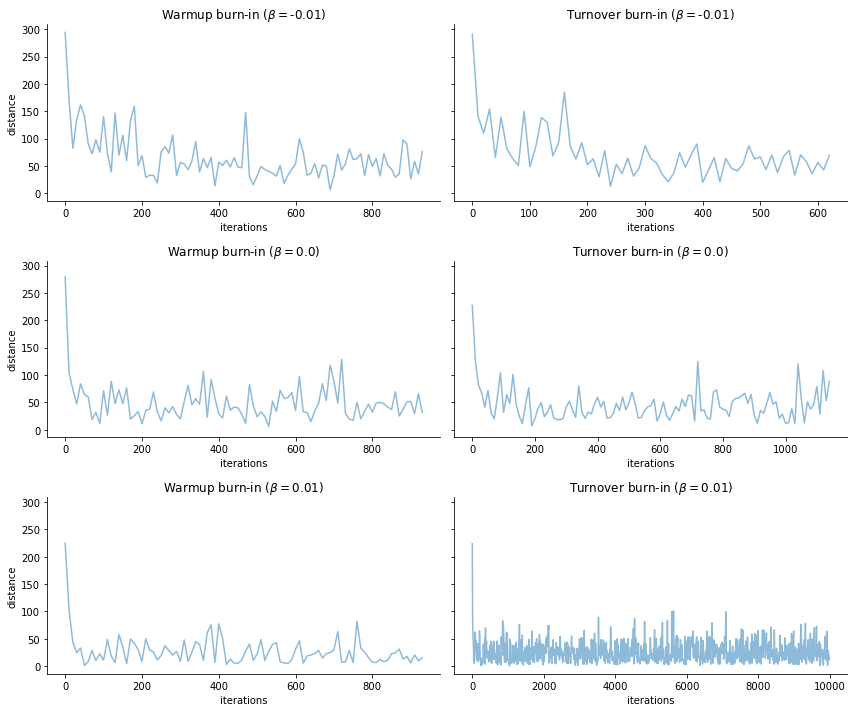

In [243]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(12, 10), ncols=2, nrows=3, sharey=True)

n_agents = 10_000
mu, p_death = 0.01, 0.5
for i, beta in enumerate((-0.01, 0.0, 0.01)):

    distances = monitor_distances(
        partial(warmup_burnin, 1000),
        n_agents, beta=beta, mu=mu, p_death=p_death
    )

    axes[i, 0].plot(np.arange(len(distances)) * 10, distances, alpha=0.5)
    axes[i, 0].set_title(fr"Warmup burn-in ($\beta = ${beta})")
    
    distances = monitor_distances(
        partial(turnover_burnin, 2),
        n_agents, beta=beta, mu=mu, p_death=p_death
    )
    
    axes[i, 1].plot(np.arange(len(distances)) * 10, distances, alpha=0.5)
    axes[i, 1].set_title(fr"Turnover burn-in ($\beta = ${beta})")
    
    for j in (0, 1):
        axes[i, j].spines["top"].set_visible(False)
        axes[i, j].spines["right"].set_visible(False)
        axes[i, j].set_xlabel("iterations")
    
    axes[i, 0].set_ylabel("distance")
        
plt.tight_layout()